In [1]:
import os
import numpy as np
# import efficientnet.tfkeras

from vit_keras import vit, utils
from tensorflow.keras.models import load_model
# validation
import pandas as pd

2023-04-10 15:34:37.379523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 15:34:37.471733: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-10 15:34:37.877353: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/kannika/miniconda3/envs/vit-tf/lib/
2023-04-10 15:34:37.877398: W tensorflow/com

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


## load model

> *1000 Epoch*

In [4]:
#load model  #ValueError: Unknown layer: 'Custom>ClassToken'
from tensorflow.keras.models import load_model

model_dir = '/media/SSD/rheology2023/VitModel/Regression/tensorflow/Exp-4/R1/models/modelRegress_ViT_l32_Rheology_R1.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]
# # model = tf.keras.models.load_model(
# #     model_dir,
# #     custom_objects={'Custom>ClassToken':tf.keras.models.Model, 'Custom>AddPositionEmbs':tf.keras.models.Model})
# # model.summary()
print(f"height: {height}, width: {width}")

2023-04-10 15:34:39.185104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 15:34:39.646210: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9438 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


height: 224, width: 224


In [5]:
model.summary()

Model: "Vit_Regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 1024)        3146752   
                                                                 
 reshape (Reshape)           (None, 49, 1024)          0         
                                                                 
 class_token (ClassToken)    (None, 50, 1024)          1024      
                                                                 
 Transformer/posembed_input   (None, 50, 1024)         51200     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 1024),       12596224  
 (TransformerBlock)           (None, 16, None, None)

## Evaluation model

In [6]:
###** Test set

dataframe = pd.read_csv('/home/kannika/codes_AI/Rheology2023/MSDT_datatest.csv')
print(dataframe.shape)
dataframe.head(5)

(870, 8)


,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset
0,0,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,158,5.63,test
1,1,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,25,0.84,test
2,2,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,7,0.25,test
3,3,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,125,4.45,test
4,4,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,19,0.63,test


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
valid_datagen = ImageDataGenerator(rescale=1./255)

val_generator = valid_datagen.flow_from_dataframe(
                dataframe = dataframe,
                directory = None,
                x_col = 'pathimg',
                y_col = 'MSDT',
                target_size = (height, width),
                batch_size=BATCH_SIZE,
                color_mode= 'rgb',
                class_mode='raw')

Found 870 validated image filenames.


In [8]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    
    return result[0]

#Predict
pred_list = list()
#prob_list = list()
img_path=dataframe['pathimg'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    pred_list.append(predict[0])
    print(predict)

2023-04-10 15:35:22.075732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-10 15:35:22.452874: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-10 15:35:22.454037: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-10 15:35:22.454070: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-10 15:35:22.454978: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-10 15:35:22.455072: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 5s 5s/step
[7.34166]
1/1 [==============================] - 0s 66ms/step
[0.635468]
1/1 [==============================] - 0s 65ms/step
[0.32921803]
1/1 [==============================] - 0s 70ms/step
[5.8441577]
1/1 [==============================] - 0s 62ms/step
[0.5374841]
1/1 [==============================] - 0s 66ms/step
[3.4986336]
1/1 [==============================] - 0s 67ms/step
[17.676336]
1/1 [==============================] - 0s 65ms/step
[34.405735]
1/1 [==============================] - 0s 74ms/step
[60.46651]
1/1 [==============================] - 0s 70ms/step
[0.22733985]
1/1 [==============================] - 0s 64ms/step
[18.264767]
1/1 [==============================] - 0s 70ms/step
[3.7058854]
1/1 [==============================] - 0s 61ms/step
[10.870265]
1/1 [==============================] - 0s 75ms/step
[0.4536394]
1/1 [==============================] - 0s 67ms/step
[1.0573746]
1/1 [==============================] - 0s 60

1/1 [==============================] - 0s 68ms/step
[0.542408]
1/1 [==============================] - 0s 62ms/step
[10.45901]
1/1 [==============================] - 0s 61ms/step
[0.83691317]
1/1 [==============================] - 0s 61ms/step
[7.21462]
1/1 [==============================] - 0s 62ms/step
[0.32821828]
1/1 [==============================] - 0s 65ms/step
[13.3484535]
1/1 [==============================] - 0s 61ms/step
[5.41191]
1/1 [==============================] - 0s 68ms/step
[15.33524]
1/1 [==============================] - 0s 65ms/step
[2.3653882]
1/1 [==============================] - 0s 67ms/step
[0.4539711]
1/1 [==============================] - 0s 66ms/step
[0.44618285]
1/1 [==============================] - 0s 58ms/step
[39.237034]
1/1 [==============================] - 0s 70ms/step
[0.27001613]
1/1 [==============================] - 0s 70ms/step
[0.4041952]
1/1 [==============================] - 0s 68ms/step
[0.17773362]
1/1 [==============================] - 0s

1/1 [==============================] - 0s 65ms/step
[1.3280478]
1/1 [==============================] - 0s 72ms/step
[6.4512277]
1/1 [==============================] - 0s 68ms/step
[11.423626]
1/1 [==============================] - 0s 69ms/step
[0.04976546]
1/1 [==============================] - 0s 62ms/step
[0.5950303]
1/1 [==============================] - 0s 66ms/step
[0.7197946]
1/1 [==============================] - 0s 87ms/step
[4.6947894]
1/1 [==============================] - 0s 59ms/step
[0.20022303]
1/1 [==============================] - 0s 60ms/step
[1.9612048]
1/1 [==============================] - 0s 64ms/step
[0.58431655]
1/1 [==============================] - 0s 67ms/step
[0.0772557]
1/1 [==============================] - 0s 62ms/step
[44.81089]
1/1 [==============================] - 0s 60ms/step
[0.57796395]
1/1 [==============================] - 0s 58ms/step
[24.667532]
1/1 [==============================] - 0s 59ms/step
[0.74852544]
1/1 [==============================]

1/1 [==============================] - 0s 63ms/step
[16.298765]
1/1 [==============================] - 0s 65ms/step
[7.7942815]
1/1 [==============================] - 0s 64ms/step
[0.30240184]
1/1 [==============================] - 0s 76ms/step
[15.690639]
1/1 [==============================] - 0s 69ms/step
[0.18576969]
1/1 [==============================] - 0s 68ms/step
[0.06798888]
1/1 [==============================] - 0s 71ms/step
[25.168018]
1/1 [==============================] - 0s 63ms/step
[9.851701]
1/1 [==============================] - 0s 64ms/step
[0.24406879]
1/1 [==============================] - 0s 62ms/step
[0.37959945]
1/1 [==============================] - 0s 69ms/step
[0.05937611]
1/1 [==============================] - 0s 68ms/step
[0.93825597]
1/1 [==============================] - 0s 72ms/step
[0.21080567]
1/1 [==============================] - 0s 68ms/step
[19.351942]
1/1 [==============================] - 0s 64ms/step
[0.5001557]
1/1 [============================

1/1 [==============================] - 0s 65ms/step
[2.1646476]
1/1 [==============================] - 0s 58ms/step
[0.04296636]
1/1 [==============================] - 0s 61ms/step
[0.16587353]
1/1 [==============================] - 0s 64ms/step
[0.14888223]
1/1 [==============================] - 0s 66ms/step
[1.8897059]
1/1 [==============================] - 0s 65ms/step
[10.960812]
1/1 [==============================] - 0s 59ms/step
[3.9749677]
1/1 [==============================] - 0s 63ms/step
[0.45087975]
1/1 [==============================] - 0s 67ms/step
[0.33504623]
1/1 [==============================] - 0s 70ms/step
[0.92145085]
1/1 [==============================] - 0s 70ms/step
[15.588466]
1/1 [==============================] - 0s 65ms/step
[0.3642164]
1/1 [==============================] - 0s 71ms/step
[0.5136095]
1/1 [==============================] - 0s 64ms/step
[0.13524586]
1/1 [==============================] - 0s 62ms/step
[1.0603887]
1/1 [============================

1/1 [==============================] - 0s 62ms/step
[0.5614261]
1/1 [==============================] - 0s 61ms/step
[1.1460043]
1/1 [==============================] - 0s 62ms/step
[0.04583239]
1/1 [==============================] - 0s 64ms/step
[0.19682115]
1/1 [==============================] - 0s 65ms/step
[0.07511306]
1/1 [==============================] - 0s 70ms/step
[0.08295028]
1/1 [==============================] - 0s 70ms/step
[0.05172431]
1/1 [==============================] - 0s 67ms/step
[0.16533317]
1/1 [==============================] - 0s 65ms/step
[0.18533067]
1/1 [==============================] - 0s 60ms/step
[0.71121573]
1/1 [==============================] - 0s 69ms/step
[0.28734407]
1/1 [==============================] - 0s 67ms/step
[1.8880779]
1/1 [==============================] - 0s 77ms/step
[1.7684551]
1/1 [==============================] - 0s 65ms/step
[7.241909]
1/1 [==============================] - 0s 70ms/step
[3.6262825]
1/1 [===========================

1/1 [==============================] - 0s 63ms/step
[0.72120965]
1/1 [==============================] - 0s 74ms/step
[0.13021713]
1/1 [==============================] - 0s 73ms/step
[0.36841333]
1/1 [==============================] - 0s 73ms/step
[0.15203634]
1/1 [==============================] - 0s 69ms/step
[0.13146523]
1/1 [==============================] - 0s 67ms/step
[0.35274082]
1/1 [==============================] - 0s 60ms/step
[0.17324999]
1/1 [==============================] - 0s 67ms/step
[0.3673296]
1/1 [==============================] - 0s 69ms/step
[0.18206014]
1/1 [==============================] - 0s 66ms/step
[0.16707665]
1/1 [==============================] - 0s 60ms/step
[1.1710678]
1/1 [==============================] - 0s 61ms/step
[0.1548362]
1/1 [==============================] - 0s 61ms/step
[0.14971566]
1/1 [==============================] - 0s 61ms/step
[0.11986889]
1/1 [==============================] - 0s 66ms/step
[0.15706319]
1/1 [=======================

In [9]:
print(len(pred_list))

dataframe['pre_MSDT'] = pred_list
dataframe.head(3)

870


,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset,pre_MSDT
0,0,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,158,5.63,test,7.341660
1,1,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,25,0.84,test,0.635468
2,2,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,7,0.25,test,0.329218


In [32]:
870/29

30.0

In [22]:
dataframe.to_csv('/home/kannika/codes_AI/Rheology2023/MSDT_test_modelRegress_ViT_l32_Rheology_R1.csv')

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


y_test = dataframe['MSDT'].tolist()
# The mean squared error
print("Root Mean squared error: %.4f" % mean_squared_error(y_test, pred_list, squared=False))
print("Mean squared error: %.4f" % mean_squared_error(y_test, pred_list))
print("Mean absolute error: %.4f" % mean_absolute_error(y_test, pred_list))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, pred_list))

Root Mean squared error: 1.5210
Mean squared error: 2.3134
Mean absolute error: 0.6990
Coefficient of determination: 0.9704


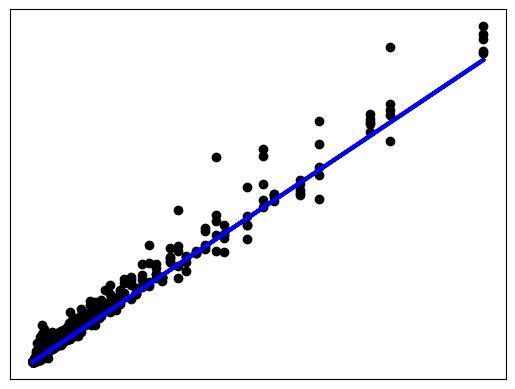

In [11]:
# Plot outputs
plt.scatter(y_test, pred_list, color="black")
plt.plot(y_test, y_test, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
import matplotlib.pyplot as plt
## setting plot style
plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(list_t, lstMSDT,
            color = "green", s = 10, label = 'Real MSDT')
## plotting residual errors in test data
plt.scatter(list_t, pred_list,
            color = "red", s = 10, label = 'Estimate MSDT')
## plotting line for zero residual error
#plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
## plotting legend
plt.legend(loc = 'upper left')
## plot title
plt.title("Predict MSDT every concentration using Visiontransformer", size=18)
plt.xlabel("t", size=14)
plt.ylabel("MSDT", size=14)
## method call for showing the plot
plt.show()

## Plot : GLY10

> ## t & msd unit

In [14]:
import random

## Set solution
G = 10
_G = f"GLY{G}"

df_idt = pd.read_csv(f'/home/kannika/codes_AI/Rheology2023/MSDT_G{G}.csv')
print(df_idt.shape)
_GLY = dataframe[dataframe['GLY']==_G]
setFolder = list(set(_GLY['folderName']))
rand = random.choices(setFolder, k=1)
rand_ = rand[0]
df_rand = _GLY[_GLY['folderName']==rand_].reset_index(drop=True)
print(df_rand.shape)
df_rand = df_rand.sort_values(by=['idt'])
list_t = df_idt['t'].tolist()
df_rand['t'] = list_t
df_rand.head(3)

(29, 3)
(29, 9)


,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset,pre_MSDT,t
25,112,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,1,0.05,test,0.195213,0.052498
12,99,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,2,0.09,test,0.115293,0.091199
4,91,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,3,0.14,test,0.259248,0.140551


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


y_testGLY10 = df_rand['MSDT'].tolist()
pred_listGLY10 = df_rand['pre_MSDT'].tolist()
# The mean squared error
print("========== Predict MSDT จาก Glycerol ความเข้มข้น 10% ==========")
print("Root Mean squared error: %.4f" % mean_squared_error(y_testGLY10, pred_listGLY10, squared=False))
print("Mean squared error: %.4f" % mean_squared_error(y_testGLY10, pred_listGLY10))
print("Mean absolute error: %.4f" % mean_absolute_error(y_testGLY10, pred_listGLY10))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_testGLY10, pred_listGLY10))
print("-"*80)

========== Predict MSDT จาก Glycerol ความเข้มข้น 10% ==========
Root Mean squared error: 1.1201
Mean squared error: 1.2547
Mean absolute error: 0.6656
Coefficient of determination: 0.9939
--------------------------------------------------------------------------------


In [16]:
#df_idt['dt'].tolist()
lstMSDT = df_rand['MSDT'].tolist() 
lstpre_MSDT = df_rand['pre_MSDT'].tolist() 
print(len(lstMSDT))
print(len(lstpre_MSDT))

29
29


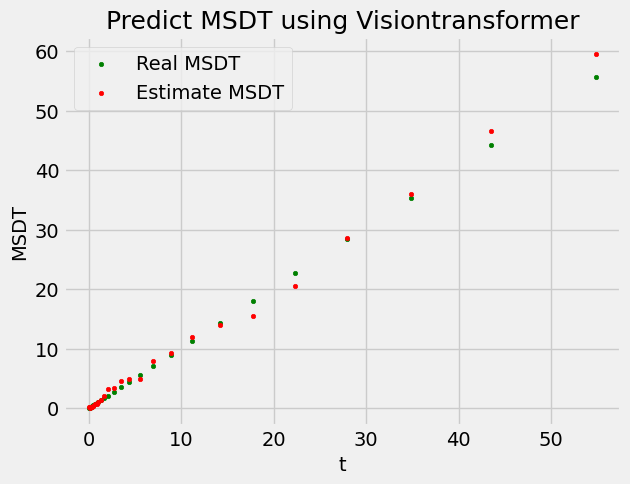

In [17]:
import matplotlib.pyplot as plt
## setting plot style
plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(list_t, lstMSDT,
            color = "green", s = 10, label = 'Real MSDT')
## plotting residual errors in test data
plt.scatter(list_t, lstpre_MSDT,
            color = "red", s = 10, label = 'Estimate MSDT')
## plotting line for zero residual error
#plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
## plotting legend
plt.legend(loc = 'upper left')
## plot title
plt.title("Predict MSDT using Visiontransformer", size=18)
plt.xlabel("t", size=14)
plt.ylabel("MSDT", size=14)
## method call for showing the plot
plt.show()

In [18]:
print(min(list_t))
print(max(list_t))

0.052498082
54.81658222


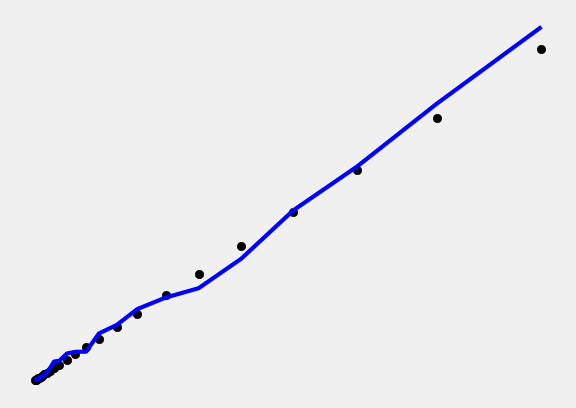

In [19]:
# Plot outputs
plt.scatter(list_t, lstMSDT, color="black")
plt.plot(list_t, lstpre_MSDT, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

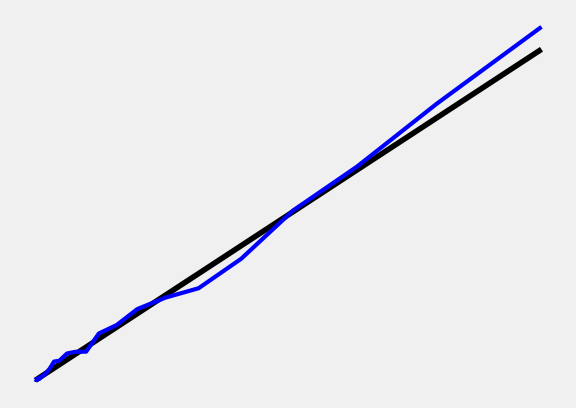

In [20]:
# Plot outputs
plt.plot(list_t, lstMSDT, color="black")
plt.plot(list_t, lstpre_MSDT, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

---------------------------------

## Plot : GLY10, 20, 30, 40, 60, 80

> ## t & msd unit

(29, 3)
[INFO] Random Folder ==> GLY10P100_D0_30HZ_20XINF_UWELL_20221230_074912
(29, 9)
========== Predict MSDT จาก Glycerol ความเข้มข้น GLY10% ==========
Root Mean squared error: 2.6717
Mean squared error: 7.1381
Mean absolute error: 1.4223
Coefficient of determination: 0.9651
--------------------------------------------------------------------------------


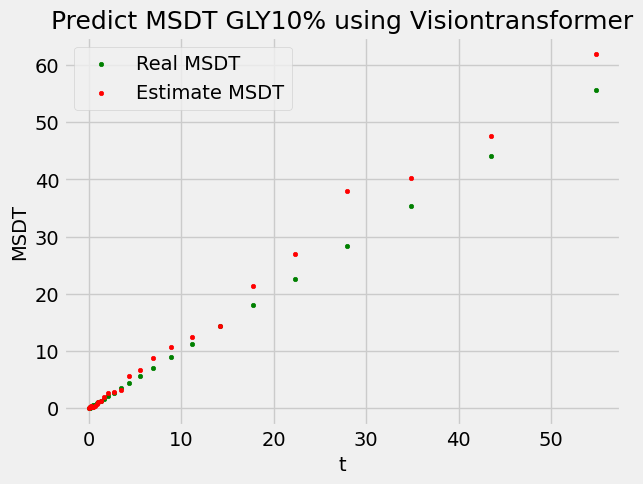

(29, 3)
[INFO] Random Folder ==> GLY20P100_D0_30HZ_20XINF_UWELL_20221227_093937
(29, 9)
========== Predict MSDT จาก Glycerol ความเข้มข้น GLY20% ==========
Root Mean squared error: 0.9092
Mean squared error: 0.8266
Mean absolute error: 0.5975
Coefficient of determination: 0.9928
--------------------------------------------------------------------------------


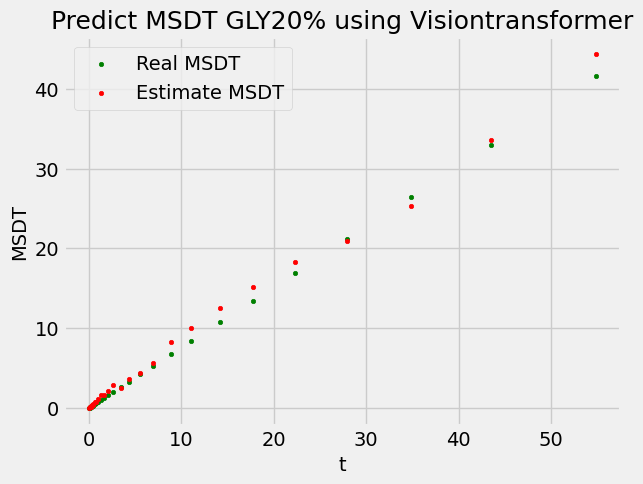

(29, 3)
[INFO] Random Folder ==> GLY30P100_D0_30HZ_20XINF_UWELL_20221228_161452
(29, 9)
========== Predict MSDT จาก Glycerol ความเข้มข้น GLY30% ==========
Root Mean squared error: 0.8612
Mean squared error: 0.7417
Mean absolute error: 0.5268
Coefficient of determination: 0.9873
--------------------------------------------------------------------------------


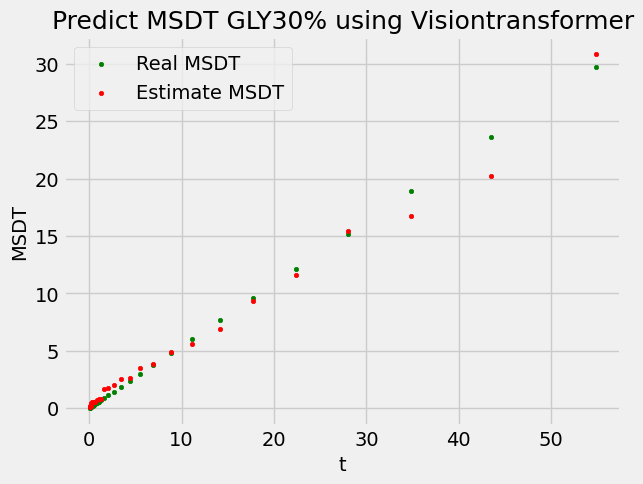

(29, 3)
[INFO] Random Folder ==> GLY40P100_D0_30HZ_20XINF_UWELL_20221227_193632
(29, 9)
========== Predict MSDT จาก Glycerol ความเข้มข้น GLY40% ==========
Root Mean squared error: 0.6326
Mean squared error: 0.4002
Mean absolute error: 0.4234
Coefficient of determination: 0.9851
--------------------------------------------------------------------------------


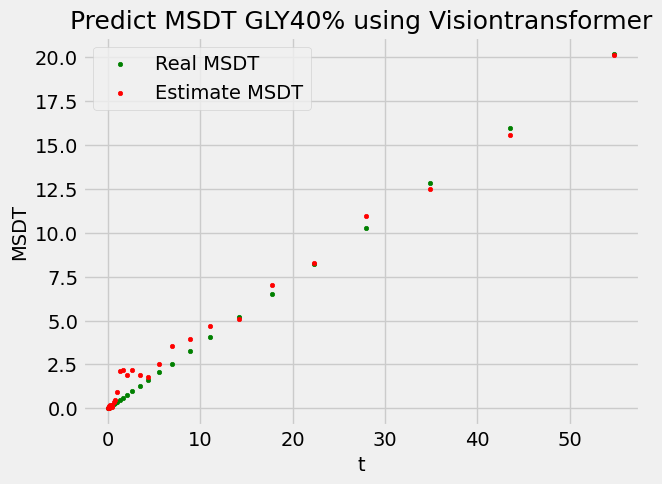

(29, 3)
[INFO] Random Folder ==> GLY60P100_D0_30HZ_20XINF_UWELL_20221228_064454
(29, 9)
========== Predict MSDT จาก Glycerol ความเข้มข้น GLY60% ==========
Root Mean squared error: 1.4065
Mean squared error: 1.9783
Mean absolute error: 0.8080
Coefficient of determination: 0.4339
--------------------------------------------------------------------------------


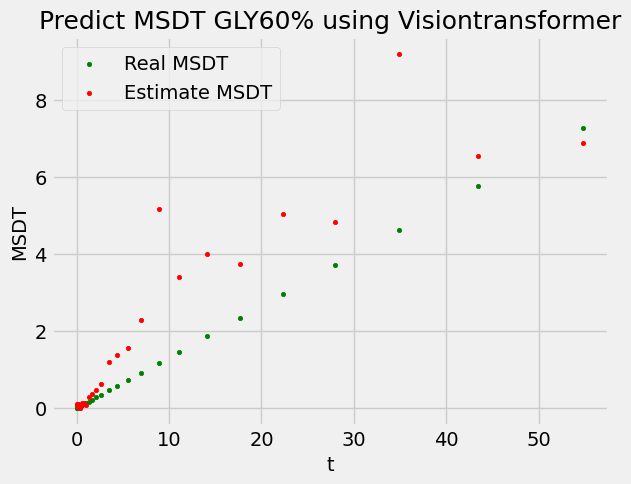

(29, 3)
[INFO] Random Folder ==> GLY80P100_D0_30HZ_20XINF_UWELL_20221228_115540
(29, 9)
========== Predict MSDT จาก Glycerol ความเข้มข้น GLY80% ==========
Root Mean squared error: 0.3314
Mean squared error: 0.1098
Mean absolute error: 0.1637
Coefficient of determination: 0.1511
--------------------------------------------------------------------------------


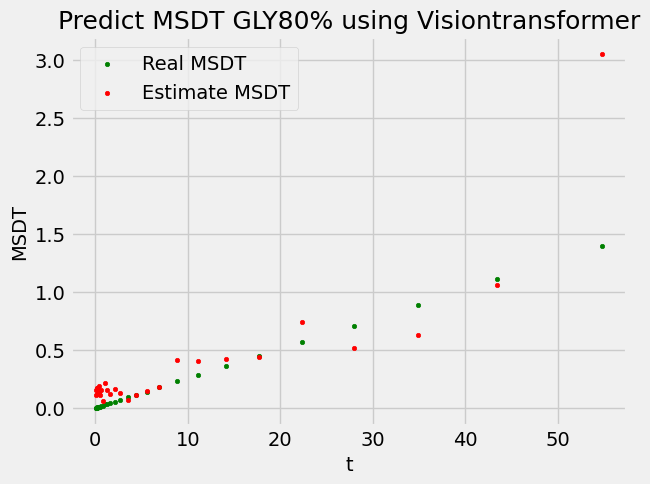

In [17]:
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

random.seed(1000)
df_rand_ = []
## Set solution
GLY = [10, 20, 30, 40, 60, 80]
for G in GLY:
#G = 10
    _G = f"GLY{G}"
    df_idt = pd.read_csv(f'/home/kannika/codes_AI/Rheology2023/MSDT_G{G}.csv')
    print(df_idt.shape)
    _GLY = dataframe[dataframe['GLY']==_G]
    setFolder = list(set(_GLY['folderName']))
    rand = random.choices(setFolder, k=1)
    rand_ = rand[0]
    print(f"---[INFO]--- Random Folder ==> {rand_}")
    df_rand = _GLY[_GLY['folderName']==rand_].reset_index(drop=True)
    print(df_rand.shape)
    df_rand = df_rand.sort_values(by=['idt'])
    list_t = df_idt['t'].tolist()
    df_rand['t'] = list_t
    df_rand_.append(df_rand)

    y_testGLY10 = df_rand['MSDT'].tolist()
    pred_listGLY10 = df_rand['pre_MSDT'].tolist()
    # The mean squared error
    print(f"========== Predict MSDT จาก Glycerol ความเข้มข้น {_G}% ==========")
    print("Root Mean squared error: %.4f" % mean_squared_error(y_testGLY10, pred_listGLY10, squared=False))
    print("Mean squared error: %.4f" % mean_squared_error(y_testGLY10, pred_listGLY10))
    print("Mean absolute error: %.4f" % mean_absolute_error(y_testGLY10, pred_listGLY10))

    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.4f" % r2_score(y_testGLY10, pred_listGLY10))
    print("-"*80)

    ## setting plot style
    plt.style.use('fivethirtyeight')

    ## plotting residual errors in training data
    plt.scatter(list_t, y_testGLY10,
                color = "green", s = 10, label = 'Real MSDT')
    ## plotting residual errors in test data
    plt.scatter(list_t, pred_listGLY10,
                color = "red", s = 10, label = 'Estimate MSDT')
    ## plotting line for zero residual error
    #plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
    ## plotting legend
    plt.legend(loc = 'upper left')
    ## plot title
    plt.title(f"Predict MSDT {_G}% using Visiontransformer", size=18)
    plt.xlabel("t", size=14)
    plt.ylabel("MSDT", size=14)
    ## method call for showing the plot
    plt.show()

## เปรียบเทียบแบบรวม (สุ่มทุกความเข้มข้นอย่างละ 1 folder)

In [18]:
print(len(df_rand_))

6


In [24]:
## concat every solute ***---29X6 = 174
df_all_GLY = pd.concat(df_rand_, ignore_index=True)
print(df_all_GLY.shape)
df_all_GLY.head()

(174, 10)


,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset,pre_MSDT,t
0,43,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_074912,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_074912...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,1,0.05,test,0.047098,0.052498
1,33,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_074912,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_074912...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,2,0.09,test,0.162259,0.091199
2,57,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_074912,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_074912...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,3,0.14,test,0.120683,0.140551
3,50,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_074912,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_074912...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,5,0.19,test,0.182385,0.190043
4,34,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_074912,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_074912...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,6,0.22,test,0.170402,0.220627


In [29]:
#list(set(df_all_GLY['folderName']))

In [30]:
#list(set(df_all_GLY['GLY']))

In [28]:
df_all_GLY.to_csv("/home/kannika/codes_AI/Rheology2023/df_all_GLY_test_modelRegress_ViT_l32_Rheology_R1.csv")

174
174
========== Predict MSDT จาก Glycerol จากทุกความเข้มข้น ==========
Root Mean squared error: 1.3659
Mean squared error: 1.8658
Mean absolute error: 0.6570
Coefficient of determination: 0.9761
--------------------------------------------------------------------------------


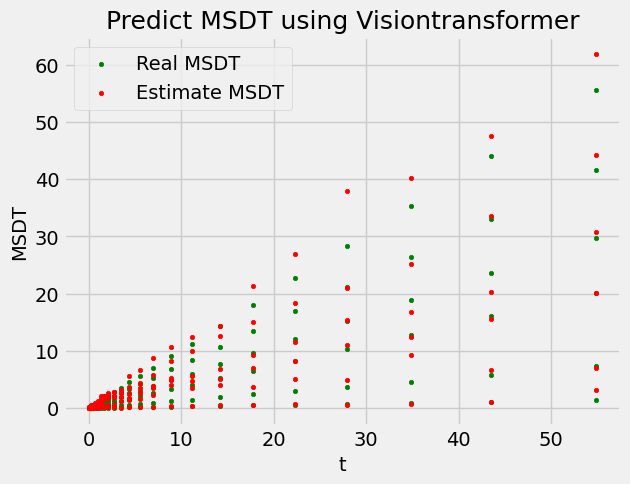

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

y_testGLY = df_all_GLY['MSDT'].tolist()
pred_listGLY = df_all_GLY['pre_MSDT'].tolist()
list_t = df_all_GLY['t'].tolist()
print(len(y_testGLY))
print(len(pred_listGLY))
# The mean squared error
print("========== Predict MSDT จาก Glycerol จากทุกความเข้มข้น ==========")
print("Root Mean squared error: %.4f" % mean_squared_error(y_testGLY, pred_listGLY, squared=False))
print("Mean squared error: %.4f" % mean_squared_error(y_testGLY, pred_listGLY))
print("Mean absolute error: %.4f" % mean_absolute_error(y_testGLY, pred_listGLY))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_testGLY, pred_listGLY))
print("-"*80)

## setting plot style
plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(list_t, y_testGLY,
            color = "green", s = 10, label = 'Real MSDT')
## plotting residual errors in test data
plt.scatter(list_t, pred_listGLY,
            color = "red", s = 10, label = 'Estimate MSDT')
## plotting line for zero residual error
#plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
## plotting legend
plt.legend(loc = 'upper left')
## plot title
plt.title("Predict MSDT using Visiontransformer", size=18)
plt.xlabel("t", size=14)
plt.ylabel("MSDT", size=14)
## method call for showing the plot
plt.show()

## 💾📂 Test Set

In [33]:
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

df_rand_ = []
## Set solution
GLY = [10, 20, 30, 40, 60, 80]
for G in GLY:
    _G = f"GLY{G}"
    df_idt = pd.read_csv(f'/home/kannika/codes_AI/Rheology2023/MSDT_G{G}.csv')
    list_t = df_idt['t'].tolist()
    print(df_idt.shape)
    _GLY = dataframe[dataframe['GLY']==_G]
    setFolder = list(set(_GLY['folderName']))
    for F in setFolder:
        df_rand = _GLY[_GLY['folderName']==F].reset_index(drop=True)
        print(df_rand.shape)
        df_rand = df_rand.sort_values(by=['idt'])
        df_rand['t'] = list_t
        df_rand_.append(df_rand)

(29, 3)
(29, 9)
(29, 9)
(29, 9)
(29, 9)
(29, 9)
(29, 3)
(29, 9)
(29, 9)
(29, 9)
(29, 9)
(29, 9)
(29, 3)
(29, 9)
(29, 9)
(29, 9)
(29, 9)
(29, 9)
(29, 3)
(29, 9)
(29, 9)
(29, 9)
(29, 9)
(29, 9)
(29, 3)
(29, 9)
(29, 9)
(29, 9)
(29, 9)
(29, 9)
(29, 3)
(29, 9)
(29, 9)
(29, 9)
(29, 9)
(29, 9)


In [34]:
print(len(df_rand_))

30


In [39]:
df_all_GLY = pd.concat(df_rand_, ignore_index=True)
print(df_all_GLY.shape)
df_all_GLY.head()

(870, 10)


,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset,pre_MSDT,t
0,144,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_071956,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_071956...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,1,0.05,test,0.129018,0.052498
1,117,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_071956,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_071956...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,2,0.09,test,0.098945,0.091199
2,142,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_071956,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_071956...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,3,0.14,test,0.177734,0.140551
3,140,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_071956,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_071956...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,5,0.19,test,0.270016,0.190043
4,123,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_071956,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_071956...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,6,0.22,test,0.292965,0.220627


In [37]:
#df_rand_[0]

In [38]:
#df_rand_[-1]

870
870
========== Predict MSDT จาก Glycerol จากทุกความเข้มข้น ==========
Root Mean squared error: 1.5210
Mean squared error: 2.3134
Mean absolute error: 0.6990
Coefficient of determination: 0.9704
--------------------------------------------------------------------------------


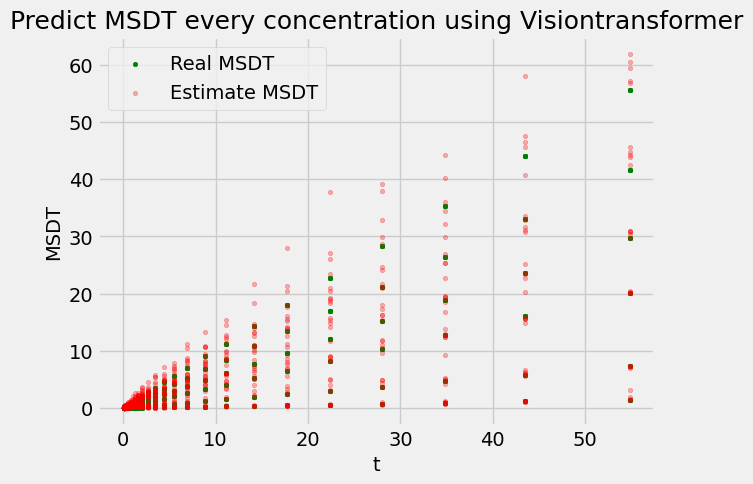

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

y_testGLY = df_all_GLY['MSDT'].tolist()
pred_listGLY =df_all_GLY['pre_MSDT'].tolist()
list_t = df_all_GLY['t'].tolist()
print(len(y_testGLY))
print(len(pred_listGLY))
# The mean squared error
print("========== Predict MSDT จาก Glycerol จากทุกความเข้มข้น ==========")
print("Root Mean squared error: %.4f" % mean_squared_error(y_testGLY, pred_listGLY, squared=False))
print("Mean squared error: %.4f" % mean_squared_error(y_testGLY, pred_listGLY))
print("Mean absolute error: %.4f" % mean_absolute_error(y_testGLY, pred_listGLY))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_testGLY, pred_listGLY))
print("-"*80)

## setting plot style
plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(list_t, y_testGLY,
            color = "green", s = 10, label = 'Real MSDT')
## plotting residual errors in test data
plt.scatter(list_t, pred_listGLY,
            color = "red", s = 10, alpha = 0.3, label = 'Estimate MSDT')
## plotting line for zero residual error
#plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
## plotting legend
plt.legend(loc = 'upper left')
## plot title
plt.title("Predict MSDT every concentration using Visiontransformer", size=18)
plt.xlabel("t", size=14)
plt.ylabel("MSDT", size=14)
## method call for showing the plot
plt.show()